In [14]:
import os
import numpy as np
import torch
import pandas as pd
# import whisper
import torchaudio
from tqdm.notebook import tqdm

from whisper.decoding import DecodingTask, DecodingOptions, DecodingResult
from whisper.blockWiseModel import Whisper as whisper
from whisper.audio import load_audio, log_mel_spectrogram, pad_or_trim
# from whisper.model import Whisper as whisper
from whisper import load_model

from dataclasses import dataclass, field, replace
from typing import TYPE_CHECKING, Dict, Iterable, List, Optional, Sequence, Tuple, Union
from torch import Tensor
# if TYPE_CHECKING:
#     from .model import Whisper

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_mels = 80 #80 #128

class audioDataset(torch.utils.data.Dataset):
    """
    A custom dataset class that takes a list of audio paths and returns the mel spectogram.
    Note:  It will trim/pad the audio to 30 seconds, as per whisper architecture.
    """

    def __init__(self, audio_paths, device=DEVICE):
        self.audio_paths = audio_paths
        self.device = device

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, item):
        audio_path = self.audio_paths[item]
        audio, sample_rate = torchaudio.load(audio_path)
        assert sample_rate == 16000
        audio = pad_or_trim(audio.flatten()).to(self.device)
        mel = log_mel_spectrogram(audio,n_mels=n_mels)
        return mel
    
@dataclass(frozen=True)
class FeatureResult:
    audio_features: Tensor
    Language: str= 'en'

@torch.no_grad()
def extractFeature(
    model,
    mel: Tensor,
    options: DecodingOptions = DecodingOptions(),
    **kwargs,
) -> Union[DecodingResult, List[DecodingResult]]:
    
    if single := mel.ndim == 2:
        mel = mel.unsqueeze(0)

    if kwargs:
        options = replace(options, **kwargs)

    decodingObject = DecodingTask(model, options)
    audio_features: Tensor = decodingObject._get_audio_features(mel)
    audio_features = audio_features[:: decodingObject.n_group]

    encoder_results = decodingObject.model.encoder.intermediate_results
    print(encoder_results)
    
    fields = (audio_features)

    if len(set(map(len, fields))) != 1:
            raise RuntimeError(f"inconsistent result lengths: {list(map(len, fields))}")

    result = [
            FeatureResult(audio_features=features)
            for features in fields
        ]

    return (result[0] if single else result),encoder_results

In [15]:
import os
import torchaudio

def read_audio_files_from_folder(folder_path):
    audio_files = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith(('.wav', '.mp3')):
            audio_files.append(file_path)
    return audio_files

folder_path = 'LanguageAudio'
audio_files = read_audio_files_from_folder(folder_path)

In [16]:
audio_files

['LanguageAudio/telugu_male.wav',
 'LanguageAudio/english.wav',
 'LanguageAudio/bengali_male.wav',
 'LanguageAudio/hindi.wav',
 'LanguageAudio/Gujarati_male.wav',
 'LanguageAudio/hindi_male.wav',
 'LanguageAudio/bengali_female.wav',
 'LanguageAudio/telugu_female.wav',
 'LanguageAudio/tamil_male.wav',
 'LanguageAudio/tamil_female.wav',
 'LanguageAudio/gujarati_female.wav']

In [17]:
model_name = "large-v2"
audio_paths = audio_files

model = load_model(model_name,device=DEVICE)

print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

options = DecodingOptions(language="en", without_timestamps=True)
dataset = audioDataset(audio_paths=audio_paths)
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

audio_features = []
intermediate_encoder = []

for mels in tqdm(loader):
    # audio_features= DecodingTask._get_audio_features(mel)  # encoder forward pass
    results,encoder_results = extractFeature(model, mels, options)
    audio_features.extend([result.audio_features for result in results])
    intermediate_encoder.append(encoder_results)

Model is multilingual and has 1,541,384,960 parameters.


  0%|          | 0/1 [00:00<?, ?it/s]

{'mel': tensor([[[-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699],
         [-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699],
         [-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699],
         ...,
         [-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699],
         [-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699],
         [-0.6699, -0.6699, -0.6699,  ..., -0.6699, -0.6699, -0.6699]],

        [[-0.4053,  0.1560,  0.2474,  ..., -0.9858, -0.9858, -0.9858],
         [-0.5361, -0.0430, -0.0060,  ..., -0.9858, -0.9858, -0.9858],
         [-0.3894, -0.2664, -0.3245,  ..., -0.9858, -0.9858, -0.9858],
         ...,
         [-0.9858, -0.9858, -0.9858,  ..., -0.9858, -0.9858, -0.9858],
         [-0.9858, -0.9858, -0.9858,  ..., -0.9858, -0.9858, -0.9858],
         [-0.9858, -0.9858, -0.9858,  ..., -0.9858, -0.9858, -0.9858]],

        [[-0.7490, -0.2698, -0.0986,  ..., -1.1445, -1.1445, -1.1445],
         [-0.8325, -0.1497,  0.0221, 

In [18]:
audio_features[0]

tensor([[ 3.9429e-02, -5.8317e-04,  3.9600e-01,  ..., -3.0332e+00,
         -3.7500e-01,  2.8345e-01],
        [ 9.4543e-02,  4.2212e-01,  3.3496e-01,  ..., -2.8008e+00,
         -3.5034e-01,  2.6953e-01],
        [ 4.2847e-01,  1.1212e-01,  5.4199e-01,  ..., -3.5078e+00,
         -2.1802e-01,  9.9463e-01],
        ...,
        [-6.0349e-03,  2.2447e-04, -1.8005e-02,  ...,  1.9592e-02,
         -8.0566e-03,  3.1734e-04],
        [-7.7133e-03,  3.1662e-03, -1.9821e-02,  ...,  1.9638e-02,
         -7.6942e-03, -9.1136e-05],
        [-5.9738e-03,  6.3667e-03, -1.5221e-02,  ...,  1.4824e-02,
         -4.6272e-03, -5.7030e-03]], device='cuda:0', dtype=torch.float16)

In [19]:
intermediate_encoder[0]['encoder'][0].shape

torch.Size([11, 1500, 1280])

In [20]:
intermediate_encoder[0]['encoder'][1].shape

torch.Size([11, 1500, 1280])

In [21]:
intermediate_encoder[0]['Conv1'].shape

torch.Size([11, 1280, 3000])

In [22]:
intermediate_encoder[0]['Conv2'].shape

torch.Size([11, 1280, 1500])

In [23]:
intermediate_encoder[0]['mel'].shape

torch.Size([11, 80, 3000])

In [24]:
# import matplotlib.pyplot as plt
# import librosa
# import librosa.display
# import numpy as np
# from scipy.signal import chirp

# # Generate chirp signal
# duration = 30  # Duration of the chirp signal in seconds
# N_FFT = 400
# HOP_LENGTH = 160
# n_mels = 80

# # Sampling rate
# SAMPLE_RATE = 16000
# t = np.linspace(0, duration, int(SAMPLE_RATE * duration), endpoint=False)
# chirp_signal = chirp(t, f0=20, f1=1000, t1=duration, method='linear')

# chirp_signal = torch.tensor(chirp_signal,dtype=torch.float)
# # print(chirp_signal)
# # spec = librosa.feature.melspectrogram(y=chirp_signal, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=n_mels)
# audio = pad_or_trim(chirp_signal.flatten())
# # print(audio)
# spec = log_mel_spectrogram(audio,n_mels=n_mels)
# spec_db = librosa.power_to_db(spec, ref=np.max)

# # Plot spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(spec_db, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
# # plt.colorbar(format='%+2.0f dB')
# plt.title('Spectrogram of Linear Chirp Signal')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.tight_layout()
# plt.show()

In [25]:
# chirp_encoder,chirp_results = extractFeature(model, spec.unsqueeze(0).to(DEVICE), options)

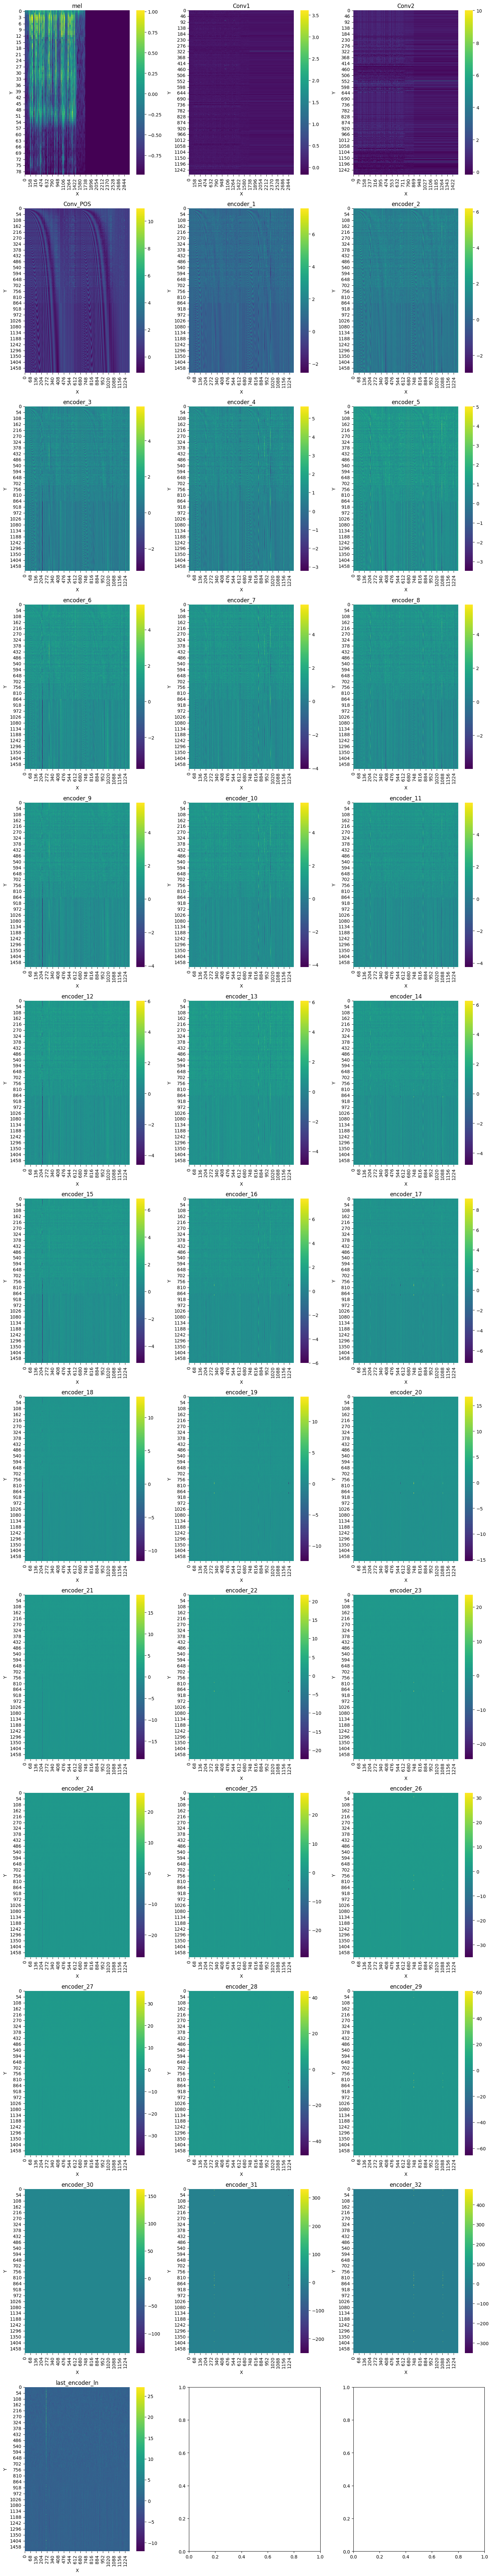

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming intermediate_encoder is a dictionary containing all the intermediate results
# Replace 'intermediate_encoder' with the actual dictionary containing your intermediate results

# Get all the keys containing feature data
feature_keys = ['mel','Conv1','Conv2','Conv_POS','encoder','last_encoder_ln']

# Plotting
num_features = 5 + len(intermediate_encoder[0]['encoder'])
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

cnt=[0,0]
for i, key in enumerate(feature_keys):
    row = cnt[0]
    col = cnt[1]

    if key=='encoder':
        for i in range(len(intermediate_encoder[0][key])):
            row = cnt[0]
            col = cnt[1]        
            features = intermediate_encoder[0][key][i][1].cpu().numpy()  # Assuming you're only interested in the first sample in the batch
            sns.heatmap(features, cmap='viridis', ax=axes[row, col])
            axes[row, col].set_title(f'{key}_{i+1}')
            axes[row, col].set_xlabel('X')
            axes[row, col].set_ylabel('Y')

            cnt[1]+=1
            if(cnt[1]==num_cols):
                cnt[1]=0
                cnt[0]+=1

    else:     
        features = intermediate_encoder[0][key][1].cpu().numpy()  # Assuming you're only interested in the first sample in the batch
        sns.heatmap(features, cmap='viridis', ax=axes[row, col])
        axes[row, col].set_title(key)
        axes[row, col].set_xlabel('X')
        axes[row, col].set_ylabel('Y')

        cnt[1]+=1
        if(cnt[1]==num_cols):
            cnt[1]=0
            cnt[0]+=1

plt.tight_layout()
plt.savefig("Large_V2_English")
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming intermediate_encoder is a dictionary containing all the intermediate results
# # Replace 'intermediate_encoder' with the actual dictionary containing your intermediate results

# # Get all the keys containing feature data
# feature_keys = ['mel','Conv1','Conv2','Conv_POS','encoder','last_encoder_ln']

# # Plotting
# num_features = 5 + len(chirp_results['encoder'])
# num_cols = 3  # Number of columns in the subplot grid
# num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

# cnt=[0,0]
# for i, key in enumerate(feature_keys):
#     row = cnt[0]
#     col = cnt[1]

#     if key=='encoder':
#         for i in range(len(chirp_results[key])):
#             row = cnt[0]
#             col = cnt[1]        
#             features = chirp_results['encoder'][i][0].cpu().numpy()  # Assuming you're only interested in the first sample in the batch
#             sns.heatmap(features, cmap='viridis', ax=axes[row, col])
#             axes[row, col].set_title(f'{key}_{i+1}')
#             axes[row, col].set_xlabel('X')
#             axes[row, col].set_ylabel('Y')

#             cnt[1]+=1
#             if(cnt[1]==num_cols):
#                 cnt[1]=0
#                 cnt[0]+=1

#     else:     
#         features = chirp_results[key][0].cpu().numpy()  # Assuming you're only interested in the first sample in the batch
#         sns.heatmap(features, cmap='viridis', ax=axes[row, col])
#         axes[row, col].set_title(key)
#         axes[row, col].set_xlabel('X')
#         axes[row, col].set_ylabel('Y')

#         cnt[1]+=1
#         if(cnt[1]==num_cols):
#             cnt[1]=0
#             cnt[0]+=1

# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming mfcc_features is your (80, 3000) array
# # mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

# mfcc_features = chirp_results['Conv1'][0].cpu().numpy()
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.heatmap(mfcc_features, cmap='viridis')
# plt.title('Feature Visualization')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming mfcc_features is your (80, 3000) array
# # mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

# mfcc_features = chirp_results['Conv2'][0].cpu().numpy()
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.heatmap(mfcc_features, cmap='viridis')
# plt.title('Feature Visualization')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming mfcc_features is your (80, 3000) array
# # mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

# mfcc_features = chirp_results['Conv_POS'][0].cpu().numpy()
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.heatmap(mfcc_features, cmap='viridis')
# plt.title('Feature Visualization')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming mfcc_features is your (80, 3000) array
# # mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

# mfcc_features = chirp_results['encoder'][1][0].cpu().numpy()
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.heatmap(mfcc_features, cmap='viridis')
# plt.title('Feature Visualization')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['mel'][0].cpu().numpy()
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['Conv1'][0].cpu().numpy()
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['Conv2'][0].cpu().numpy()
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['Conv_POS'][0].cpu().numpy()
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['encoder'][0][0].cpu().numpy()
print(mfcc_features.shape)
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mfcc_features is your (80, 3000) array
# mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

mfcc_features = intermediate_encoder[0]['encoder'][10][0].cpu().numpy()
print(mfcc_features.shape)
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_features, cmap='viridis')
plt.title('Feature Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming mfcc_features is your (80, 3000) array
# # mfcc_features = np.random.rand(80, 3000)  # Replace this with your actual data

# mfcc_features = intermediate_encoder[0]['encoder'][5][0].cpu().numpy()
# # Plotting
# plt.figure(figsize=(10, 6))
# sns.heatmap(mfcc_features, cmap='viridis')
# plt.title('Encoder 6 Visualization')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

All Layers: Chirp Signal

Relu vs Gelu

In [ ]:
# Create a subplot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

feature_gelu = chirp_results['Conv1'][0].cpu().numpy()
feature_relu = chirp_results['conv1_Relu'][0].cpu().numpy()

# Plot the heatmaps on each subplot
sns.heatmap(feature_gelu, cmap='viridis', ax=ax1)
ax1.set_title('Conv1 Feature Visualization (Gelu)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

sns.heatmap(feature_relu, cmap='viridis', ax=ax2)
ax2.set_title('Conv1 Feature Visualization (Relu)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Adjust layout and show the plot
plt.tight_layout()

In [ ]:
# Create a subplot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

feature_gelu = chirp_results['Conv2'][0].cpu().numpy()
feature_relu = chirp_results['conv2_Relu'][0].cpu().numpy()

# Plot the heatmaps on each subplot
sns.heatmap(feature_gelu, cmap='viridis', ax=ax1)
ax1.set_title('Conv2 Feature Visualization (Gelu)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

sns.heatmap(feature_relu, cmap='viridis', ax=ax2)
ax2.set_title('Conv2 Feature Visualization (Relu)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Adjust layout and show the plot
plt.tight_layout()